In [1]:
# imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly_express as px
import datetime

import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel

import pyLDAvis.gensim_models

import warnings

/Users/rfunke/miniforge3/envs/sma/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [2]:
# loading dataframe
df = pd.read_pickle('./bundestag_PMs.pkl')

# SMA Portfolio Exam 2
## Part 2 - Filtering

During the preliminary research we found that a lot of press releases by the german parliament are of a orginizational matters regarding public events like:
- Öffentliche Sitzung
- Öffentliche Anhörung
- Öffentliches Fachgespräche
- Öffentliche Zeugenvernehmung

If we were to try to extract topic from the dataset as is, the high proportion of press releases regarding public events would dominate all other topics and make a granual topic modelling difficult.

Eventhough we could filter these occurrences by searching the title column for suitable keywords, we are going to attempt to filter these out using the Latent-Dirichlet-Allocation.

This would leave us with a remaining set of press releases that we will mine again in an attempt to extract a meaningful topic allocation.

In [3]:
# to prevent depreciation warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category=DeprecationWarning)
    # plot a timeseries of the total number of articles per day
    fig = px.line(
        df,
        x=df.groupby(df['date']).count().index,
        y=df.groupby(df['date'])['title'].count(),
        title='Number of press releases published per day',
        labels={
            'y': 'Number of Articles',
            'x': 'Date'})

    fig.add_vrect(x0="2021-07-09", x1="2021-09-26", 
            annotation_text="Election Campaigning", annotation_position="top right",
            fillcolor="green", opacity=0.25, line_width=0)

    fig.add_vrect(x0="2021-10-01", x1="2021-12-06", 
            annotation_text="Coalition Negotiations", annotation_position="top left",
            fillcolor="green", opacity=0.25, line_width=0)

    fig.add_vline(x=datetime.datetime(2022,2,24).timestamp() * 1000,
            line_width=2, line_dash="dot", line_color="red",
            annotation_position="bottom right",
            annotation_font_color="red", 
            annotation_text="Invasion Ukraine")
    fig.show()

When plotting the number of press releases per day for the given period we find to periods when there we fewer releases:
- July 2021 to March 2022
- July 2022 to September 2022

The dropping number of press releases going into July corresponds with the summer break, though it is curios to see difference in the number of releases between January 2021 and January 2022.

April 4th of 2021 is an obvious outlier with 15 press releases that day.

In [4]:
# press releases on April 4th, 2021
df[df.date == '2021-04-08'][['title']]

,title
8,Öffentliche Sitzung des Familienausschusses zu...
91,Öffentliche Sitzung des Ausschusses für Verkeh...
262,Öffentliche Sitzung des Ausschusses für Recht ...
269,Öffentliche Sitzung des 3. Untersuchungsaussch...
327,Öffentliche Sitzung des Finanzausschusses zum ...
408,Öffentliche Sitzung des Ausschusses für Gesund...
442,Öffentliche Sitzung des Ausschusses für Arbeit...
459,Öffentliche Sitzung des Parlamentarischen Beir...
552,Öffentliche Sitzung des Innenausschusses zur A...
641,Öffentliche Sitzung des Umweltausschusses zur ...


As we see above all the press releases on April 4th, 2021 are regarding public sessions. The high proportion of these in the dataset is why we are going to attempt to filter them out, before mining for further topics.

# Text cleaning and tokenizing

Part of the text cleaning process is to use a collection of stop words, that prevent a specific word from being tokenized. There are list of stop words available for the german language that we can use in this application.

When reading through the press release during the preliminary analysis, it became obvious that we will have to extend the list of stop word. This includes the abrevations of political parties, the names of months and dates as well as 'zeit' und 'ort'.

During first trails of the LDA analysis it also became apparent that 'dr', 'deutschland', 'deutscher', 'deutschen', 'bundestag' and 'bundestages' will have to be filtered out.

In [5]:
# stops words sourced from https://countwordsfree.com/stopwords/german

with open('stop_words_german.txt', 'r') as my_file:
    # reading the file
    data = my_file.read()

# replacing end of line('/n') with ' ' and
# splitting the text it further when ' ' is seen.
more_german_stopwords = data.replace('\n', ' ').split(' ')

In [6]:
# additional lists of stop words
months = [
    'januar', 'februar', 'märz', 'april', 'mai', 'juni',
    'juli', 'august', 'september', 'oktober', 'november', 'dezember']

days = ['montag', 'dienstag', 'mittwoch', 'donnerstag', 'freitag', 'samstag', 'sonntag']

parties = ['spd', 'fdp', 'grünen', 'cducsu', 'afd', 'linke']

In [7]:
# loading german stop words from nltk library
stop_words = nltk.corpus.stopwords.words('german')

# extending stop words
stop_words.extend(more_german_stopwords)
stop_words.extend(months)
stop_words.extend(days)
stop_words.extend(parties)
stop_words.extend(
    ['-', 'dr', 'deutschland', 'deutscher', 'deutschen',
    'bundestag', 'bundestages', 'zeit', 'ort'])

# instantiating whitespace tokenizer
wpt = nltk.WhitespaceTokenizer()

# function to clean and tokenize texts
def clean(doc):
    # lower casing string
    doc = doc.lower()

    # removing in string containing 'www'
    doc = re.sub(r'www\S*', ' ', doc)
    
    # removing in string containing 'https'
    doc = re.sub(r'https\S*', ' ', doc)

    # substituing missing and double whitespaces after periods
    doc = re.sub(r'\.(?! )', '. ', re.sub(r' +', ' ', doc))

    # removing numbers
    doc_nonum = re.sub(r'\d+', ' ', doc)
    
    # replacing any character that is not a word character, whitespace or a hyphen
    doc = re.sub(r'[^-\w\s]', '', doc_nonum)
    
    # tokenizing
    tokens = wpt.tokenize(doc)
    
    # adding tokens to list if not in stop_words
    cleaned_tokens = [token for token in tokens if token not in stop_words]
    return cleaned_tokens

In [8]:
# applying function to each row in text column
df['cleaned'] = df.text.apply(clean)

In [9]:
# storing dataframe
df.to_pickle('./bundestag_PMs_tokenized.pkl')

## Create Bag of Words

In [10]:
# loading dataframe
df = pd.read_pickle('./bundestag_PMs_tokenized.pkl')

In the first iteration of the analysis we will create a dictionary from the list of tokens per press release. To get a broad understanding of the topic we are not going to filter the dictionary at first.

In [11]:
# creating dictionary from tokens
dictionary = Dictionary(df.cleaned)

# printing ten most common tokens in dictionary
print(f'Ten most common words:\n{dictionary.most_common(10)}')

# printing length of dictionary
print(f'\nTokens in dictionary: {len(dictionary)}')

Ten most common words:
[('sitzung', 1132), ('finden', 607), ('informationen', 581), ('anhörung', 564), ('ausschusses', 541), ('parlament', 497), ('internetseite', 495), ('detaillierte', 480), ('sitzungssaal', 444), ('abgeordneten', 406)]

Tokens in dictionary: 19371


In [12]:
# creating corpus from dictionary
corpus = [dictionary.doc2bow(text) for text in df.cleaned]

# Determining optimal number of topics

In [13]:
# Choose number of topics to maximize topic coherence'

topics = []
coherence = []
for i in range(2, 16):
    # configuring LDA model
    ldamodel = LdaModel(
        corpus=corpus,
        num_topics=i,
        id2word=dictionary,
        iterations=1000,
        alpha='auto',
        random_state=1,
        passes=5)
    
    # calculating coherence score for each number of topics
    u_mass = CoherenceModel(
        model=ldamodel,
        corpus=corpus,
        dictionary=dictionary,
        coherence='u_mass')
        
    topics.append(i)
    coherence.append(u_mass.get_coherence())

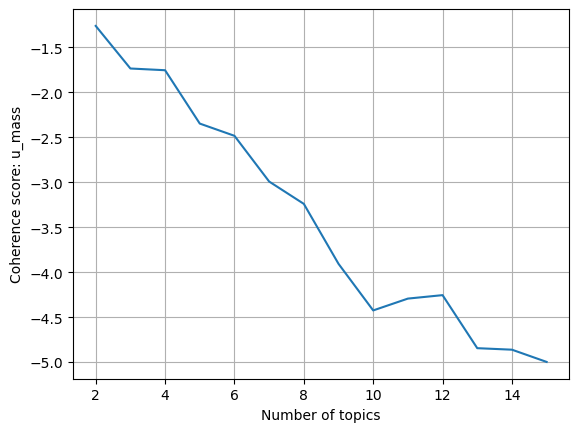

In [14]:
# Create a figure and axes
fig, ax = plt.subplots()

# Axis labels
plt.xlabel('Number of topics')
plt.ylabel('Coherence score: u_mass')

# Plot the data
ax.plot(topics, coherence)

# Turn on grid lines
ax.grid(True)

# Show the plot
plt.show()

When running the LDA analysis on a corpus built from an unfiltered dictionary, the model with two topics scores the highest coherence score, which continues to drop further with each step.

Since we want to filter out all press releases about pubilc events, we are going to see if can seperate the dataset into two topics. Where one topic contains all press releases about public events, while the second topic groups all other releases.

## Run LDA Algorithm

In [15]:
# settings number of topics
num_topics=2

# configuring LDA model
lda = LdaModel(
   corpus=corpus,
   num_topics=num_topics,
   id2word=dictionary,
   iterations=5000,
   alpha='asymmetric',
   passes=25,
   eval_every=1,
   random_state=1)

## Interpretation

In [16]:
# getting 15 most common words per topic
topics_list = []
for topic in np.arange(num_topics):
    topics_list.append(lda.show_topic(topic, topn=15))

# printing 15 most common words per topic
for i in range(len(topics_list)):
    probs = pd.DataFrame(topics_list[i], columns =['Word', 'Probability']) 
    probs = probs.sort_values('Probability', ascending=False)
    probs = probs.style.set_caption(f'TOPIC {i}')
    display(probs)

,Word,Probability
0,sitzung,0.024617
1,anhörung,0.012278
2,informationen,0.012085
3,finden,0.011830
4,ausschusses,0.011141
5,internetseite,0.010778
6,detaillierte,0.010453
7,sitzungssaal,0.009670
8,paul-löbe-haus,0.008777
9,öffentliche,0.008701


,Word,Probability
0,parlament,0.008369
1,ukraine,0.003656
2,delegation,0.003004
3,interview,0.002406
4,eu,0.002061
5,europäischen,0.002044
6,abgeordneten,0.001967
7,russland,0.001870
8,europa,0.001756
9,bundesregierung,0.001741


In [17]:
# storing document topics
document_topics = lda.get_document_topics(corpus,  minimum_probability=0)

# sorting document topic by most likely topic per document
sorted_doc_topics = [
    sorted(doc, key=lambda x:x[1], reverse=True) for doc in document_topics]

# creating column 'topic' for topic number
df['topic'] = [doc[0][0] for doc in sorted_doc_topics]

## Evaluating attempt to filter press releases about public events

Each press release was assigned with the number of the most likely topic.

This allows us to compare the number of press releases that we assigned with topic 0 and the number press releases containing some spelling variation of 'öffentlich'.

In [18]:
# filtering for 'öffentlich' or 'öffentlich'
len(df[df['title'].str.contains('Öffentlich|öffentlich')])

516

There are 516 press releases containing some spelling variation of 'öffentlich' in the title.

In [19]:
# counting number of press releases per topic

# to prevent depreciation warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fig = px.pie(df.topic.value_counts(), values=df.topic.value_counts().values,
        names=df.topic.value_counts().index, hole=0.236,
        height=600,
        title='Topic Distribution')

    fig.update_traces(textposition='inside', textinfo='percent+label', showlegend=False)
    fig.show()

In [20]:
# counting examples which contain 'Öffentlich' or 'öffentlich' in the title
len(df[df['title'].str.contains('Öffentlich|öffentlich')])

516

Of 889 press releases 628 we assigned to topic 0. While we find 516 results when filtering for the keywords 'Öffentlich' or 'öffentlich' which means we 'over filtered' by 112 press releases.

In [21]:
# exploring 'over filtered' cases
# dataframe for topic 0
df_public = df[df.topic == 0]

# filtering dataframe for examples without 'Öffentlich' or 'öffentlich' in the title
df_temp = df_public[df_public['title'].str.contains('Öffentlich|öffentlich') == False]
len(df_temp)

155

The approach of using LDA to filter out all press releases regarding public events, worked but only to some degree. When we filter topic 0 to not include 'Öffentlich' or 'öffentlich' in the title, we get 155 results. Those 155 press releases would belong to topic 1, we shall take a look at the titles of some samples to confirm.

In [22]:
# 25 sample headlines of topic 0
# excluding titles containing 'Öffentlich' or 'öffentlich'
display_length = pd.get_option('display.max_colwidth')
pd.set_option('display.max_colwidth', None)
df_temp[['title']].sample(25)

,title
10,BILDTERMIN: Bundestagspräsidentin Bas empfängt den Präsidenten der Parlamentarischen Versammlung des Europarates
697,30. Jahrestagung der Ostseeparlamentarierkonferenz am 30. August 2021
744,Das Maskottchen der Kinderkommission des Deutschen Bundestages heißt Kiko!
215,„Bürgerräte – Instrument der Bürgerbeteiligung in der repräsentativen Demokratie“ – eine Diskussion beim „Forum W“ im Bundestag
857,BILDTERMIN: Bundestagspräsidentin Bas empfängt die Präsidentin des tschechischen Parlaments
48,Bundestagspräsident Schäuble beim virtuellen Auftakt der Ausstellung „Shared History“ über 1700 Jahre jüdisches Leben im deutschsprachigen Raum
378,31. Versammlung der Ostseeparlamentarierkonferenz in Stockholm im Zeichen des Krieges gegen die Ukraine
828,Bundestagsvizepräsidentin Claudia Roth besucht Gedenkveranstaltung zum 80. Jahrestag des Massakers von Kragujevac
415,Deutscher Bundestag gedenkt der Opfer des Nationalsozialismus
319,Pressekonferenz der Präsidentinnen des Bundestages und der Assemblée nationale / Deutsch-Französische Parlamentarische Versammlung befragt Baerbock und französische Staatssekretärin Boone


In [23]:
# reverting settings from cell above
pd.set_option('display.max_colwidth', display_length)

Beyond the already mentioned public events, 'BILDTERMIN' seems to have a high occurance as well. Though there are some press releases that might fit better in topic 1. Some of those are:
- Parlamentarische Versammlung des Europarates berät über Lage von Alexei Nawalny
- Deutsch-Französische Parlamentarische Versammlung mit Befragung 
- Konstituierung des Unterausschusses „Bürgerschaftliches Engagement“ in Anwesenheit von Bundesfamilienministerin Spiegel
- Parlamentarische Versammlung des Europarates debattiert Konsequenzen aus der Covid-19-Pandemie und befragt ungarischen Europaratsvorsitz
- Eine Delegation des Verteidigungsausschusses reiste vom 24. bis 27. Oktober 2022 nach Jordanien und in den Irak
- Solidaritätsschreiben des Bundestages und des Bundesrates an das Schattenparlament Myanmars

Within these 25 samples of 155 press releases we do find a range of titles regarding foreign and domestic politics that might provide interesting material for our attempts of topic modelling.

In [24]:
# forming dataframe excluding topic 0
df = df[df.topic == 1]

# resetting index of dataframe
df = df.reset_index(drop=True)

# dropping topic column
df = df.drop(['topic'], axis=1)

In [25]:
# to prevent depreciation warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    # plot a timeseries of the total number of articles per day
    px.line(df,
        x=df.groupby(df['date']).count().index,
        y=df.groupby(df['date'])['title'].count(),
        title='Number of press releases published per day',
        labels={
            'y': 'Number of Articles',
            'x': 'Date'}).show()

When plotting the number of press releases a day for topic 1, we get a more consistent pattern than above on the full dataset, except for the peak of October 21st in 2022.

In [26]:
# printing titles for press releases of October 21st, 2022
df[df.date == '2022-10-21'][['title']]

,title
18,Ausschuss für Menschenrechte reist nach Taiwan...
37,Parlamentariergruppe der Arabischsprachigen St...
50,Umweltausschuss reist nach Indien
103,„Drei plus drei wäre die richtige Antwort“Der ...
108,Trilaterale Präsidiumssitzung in Augsburg fäll...
195,Haushaltsausschuss reist in die Republik Molda...


Upon a closer look,the titles suggest October 21st of 2022 was actually a regular day.

# Conclusion Filtering

Eventhough the idea of filtering out public events using topic modelling didn't work quite perfectly, we are going to continue with the approach.

In the next step we are going to attempt to extract meaningful topic from the remaining 261 press releases that weren't concerning public parliamental events.

In [27]:
# storing filtered dataframe
df.to_pickle('./bundestag_PMs_filtered.pkl')